### Recipe Cropper
_Automates the process of removing backgrounds from our recipe images. It works by sending an image to an API endpoint, which will then be processed by a ML model and returned to the user with the background removed._

- The image can be provided via URL or DBFS path.
- The result will be returned as an S3 object URL.
- Note that the API requires a Databricks bearer token for authentication.

**API endpoint**: `https://company.cloud.databricks.com/serving-endpoints/oma-recipecropper-v1/invocations`

- `headers = {"Authorization": f"Bearer <DATABRICKS_TOKEN>", "Content-Type": "application/json"}`
- `data = {"inputs": {"image_path": "<IMAGE_URL>"}}`

#### Requirements
- Upgrade `pip` & install libraries
- Check library versions

In [0]:
!pip install -q --upgrade pip

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install -U -q mlflow mlflow[extras] transformers torch torchvision evaluate accelerate ipywidgets datasets boto3

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
# Check library versions
import sys
import mlflow
import transformers
import torch
import torchvision
import evaluate
import accelerate
import ipywidgets
import pyspark
import datasets

print("python version:", sys.version)
print("mlflow version:", mlflow.__version__)
print("transformers version:", transformers.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("evaluate version:", evaluate.__version__)
print("accelerate version:", accelerate.__version__)
print("ipywidgets version:", ipywidgets.__version__)
print("pyspark version:", pyspark.__version__)
print("datasets version:", datasets.__version__)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5d70f05e10>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
mlflow version: 2.15.1
transformers version: 4.44.0
torch version: 2.4.0+cu121
torchvision version: 0.19.0+cu121
evaluate version: 0.4.2
accelerate version: 0.33.0
ipywidgets version: 8.1.3
pyspark version: 3.5.0
datasets version: 2.20.0


#### Import Libraries

In [0]:
import os
import sys
import random
from typing import Callable, Tuple
import logging
import requests
from io import BytesIO
import base64
import json

import numpy as np
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import jaccard_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import mlflow
import mlflow.pyfunc
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
import torch.multiprocessing as mp
import torchvision.transforms as T

from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

import boto3

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3370ae3f40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


##### Set environment variables

In [0]:
# Databricks credentials
os.environ["DATABRICKS_HOST"] = "https://company.cloud.databricks.com"
os.environ["DATABRICKS_TOKEN"] = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()

#### Load Dataset
- Create `CustomSegmentationDataset` which inherits from `PyTorch Dataset` class. Requires implementing the methods:
  - `__len__`: Returns the total number of image/annotation pairs in the dataset.
  - `__getitem__`: Retrieves and proceses and image/annotation pair at a specified index.
- Implement data augmentation.
- Create `map_labels` function to map labels to `[0, 1]`.
- Create datasets:
  - Split dataset into training, validation, and test sets using `train_test_split`.
  - Create a dataset instance with the entire dataset for K-Fold Cross-Validation.

We will be using SegFormer as base model ([HuggingFace documentation](https://huggingface.co/docs/transformers/en/model_doc/segformer)), therefore also `SegformerImageProcessor` as feature extractor.

In [0]:
# Set dataset name
dataset_name = "step_dataset_01"

In [0]:
class CustomSegmentationDataset(Dataset):
  """
  A custom dataset class for loading image/annotation pairs for segmentation tasks.

  This dataset class is used with a DataLoader to load images and their corresponding
  annotations, preprocess them using a feature extractor, and map the raw labels to
  corrected labels.

  Args:
    image_dir: Path to the directory containing image files.
    annotation_dir: Path to the directory containing annotation files.
    feature_extractor: The feature extractor for the images and annotations.
    label_mapper: A function to map raw lablels to corrected labels.
    image_files: List of image file names.
    annotation_files: List of annotation file names.
    agumentation: Whether to apply data augmentations.
    percentage: Percentage of the dataset to use.
  """
  def __init__(self, 
               image_dir: str, 
               annotation_dir: str, 
               feature_extractor: SegformerFeatureExtractor, 
               label_mapper: Callable, 
               image_files: list[str] = None, 
               annotation_files: list[str] = None,
               augmentation: bool = True,
               percentage: float = 1.0):
    self.image_dir = image_dir
    self.annotation_dir = annotation_dir
    self.feature_extractor = feature_extractor
    self.label_mapper = label_mapper
    
    # If no image_files/annotation_files list is provided, generate it from the image directory
    self.image_files = self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]) if image_files is None else image_files
    self.annotation_files = sorted([f for f in os.listdir(annotation_dir) if f.endswith(".png")]) if annotation_files is None else annotation_files
    assert len(self.image_files) == len(self.annotation_files), "Number of images and annotations should be the same"

    self.augmentation = augmentation

    # Randomly sample a subset of the dataset
    if percentage < 1.0:
      subset_size = int(len(self.image_files) * percentage)
      indices = random.sample(range(len(self.image_files)), subset_size)
      self.image_files = [self.image_files[i] for i in indices]
      self.annotation_files = [self.annotation_files[i] for i in indices]

  def __len__(self) -> int:
    """
    Returns the total number of image/annotation pairs.

    Returns:
      The number of image/annotation pairs.
    """
    return len(self.image_files)
  
  def __getitem__(self, idx: int) -> (torch.Tensor, torch.Tensor):
    """
    Retrieves the image and its corresponding annotation at the given index.

    Args:
      idx: Index of the image/annotation pair to retrieve.

    Returns:
      A tuple containing the pixel values and labels tensors.
    """
    # Get file paths
    image_path = os.path.join(self.image_dir, self.image_files[idx])
    annotation_path = os.path.join(self.annotation_dir, self.annotation_files[idx])

    # Load and convert image to RGB and annotation to grayscale
    image = Image.open(image_path).convert("RGB")
    annotation = Image.open(annotation_path).convert("L")

    # Apply augmentations using a fixed seed for reproducibility
    if self.augmentation:
      seed = torch.randint(0, 2**32, (1,)).item()
      image, annotation = augment(image, annotation, seed)

    # Correct labels using label mapper
    raw_labels = torch.tensor(np.array(annotation))
    corrected_labels = self.label_mapper(raw_labels)

    # Use feature extractor to process image and labels
    encoded_inputs = self.feature_extractor(image, corrected_labels, return_tensors="pt")

    # Get pixel values and labels from encoded inputs
    pixel_values = encoded_inputs["pixel_values"].squeeze(0)
    labels = encoded_inputs["labels"].squeeze(0)

    return pixel_values, labels

In [0]:
# Data Augmentation
def augment(image: Image.Image, mask: Image.Image, seed: int) -> Tuple[Image.Image, Image.Image]:
    """
    Apply data augmentation to an image and it's mask.

    This function performs the following augmentations:
        1. Color jitter: Randomly changes brightness, contrast, saturation, and hue.
        2. Random affine transformation: Applies random rotation, translation, scaling, and shearing.
        3. Horizontal flip: Randomly flips the image and mask horizontally.
        4. Vertical flip: Randomfly flips the image and mask vertically.
        5. Rotation: Rotates the image and mask by a random angle.

    Args:
        image: The input image to be augmented.
        mask: The corresponding segmentation mask of the input image.
        seed: Random seed for reproducibility.

    Returns:
        Tuple with the the augmented image and mask.
    """
    torch.manual_seed(seed)

    # ColorJitter
    color_jitter = T.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.2
    )
    image = color_jitter(image)

    # RandomAffine
    random_affine = T.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    )
    image = random_affine(image)
    mask = random_affine(mask)

    # Horizontal Flip
    if random.random() > 0.5:
        image = T.functional.hflip(image)
        mask = T.functional.hflip(mask)

    # Vertical Flip
    if random.random() > 0.5:
        image = T.functional.vflip(image)
        mask = T.functional.vflip(mask)

    # Rotation
    angle = random.uniform(-45, 45)
    image = T.functional.rotate(image, angle)
    mask = T.functional.rotate(mask, angle, interpolation=T.InterpolationMode.NEAREST)

    return image, mask

In [0]:
# Label mapping
def map_labels(label_tensor: torch.Tensor) -> torch.Tensor:
    """
    Maps specific labels in a PyTorch tensor to new values.

    Args:
        label_tensor: Input PyTorch tensor containing labels.

    Returns:
        Mapped labels as a PyTorch tensor.
    """
    label_tensor = label_tensor.clone().detach().type(torch.uint8)
    label_tensor[label_tensor == 38] = 1  # Map label 38 to 1
    label_tensor[label_tensor == 0] = 0  # Ensure label 0 remains 0
    return label_tensor

##### Creating datasets
  - `dataset` contains the entire dataset for K-Fold Cross-Validation.
  - `train_dataset` contains the training dataset as split by `train_test_split`
  - `valid_dataset` contains the validation dataset as split by `train_test_split`
  - `test_dataset` contains the testing dataset as split by `train_test_split`

When initializing the feature extractor `SegformerImageProcessor` we can set:
- `reduce_labels=True` will replacee 0 in the annotated maps by 255, which is the `ignore_index` of the loss function used by `SegformerForSemanticSegmentation`.
- `reduce_lables=False` will leave 0 untouched, as it's the index of the background class and will include this class as part of all labels.

In [0]:
# Paths to dataset
root_dir = f"<PATH>/PoC/{dataset_name}/"
img_dir = os.path.join(root_dir, "images")
ann_dir = os.path.join(root_dir, "annotations")

# List all image and annotation files
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith((".png", ".jpg", ".jpeg"))])
annotation_files = sorted([f for f in os.listdir(ann_dir) if f.endswith(".png")])

# Split data intro training, validation, and test sets
train_imgs, test_imgs, train_anns, test_anns = train_test_split(image_files, annotation_files, test_size=0.1, random_state=42)
train_imgs, valid_imgs, train_anns, valid_anns = train_test_split(train_imgs, train_anns, test_size=0.2, random_state=42)

# Init feature extractor
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, do_rescale=False)

# Create dataset instances
dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor, map_labels, percentage=1)
train_dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor, map_labels, train_imgs, train_anns, augmentation=False, percentage=0.5)
valid_dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor, map_labels, valid_imgs, valid_anns, augmentation=False, percentage=0.5)
test_dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor, map_labels, test_imgs, test_anns, augmentation=False, percentage=0.5)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-3613ced3-0543-4f4e-bebe-15790092bc85/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [0]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))
print("Total number of examples:", len(dataset))

Number of training examples: 2310
Number of validation examples: 577
Number of testing examples: 321
Total number of examples: 6417


#### Train Model

- Define training parameters
- Create `train` and `evaluate` functions
- Implement early stopping.
- Train the model using one of:
  1. `train`/`validation`/`test` splits.
  2. K-Fold Cross-Validation with entire `dataset`.
  3. Distributed Training with `train`/`validation`/`test` splits.

##### Training parameters

**`batch_size`**:
- **DataLoader**: Determines how many samples are loaded and processed at once. Larger batches require more memory.
- **Training**: Affects the stability of training. Larger batches require more resources but provide more stable and accurate estimates of gradients, leading to smoother convergence.
- **Trade-off**: Smaller batches introduce more noise in the gradient estimates, which can help escape local minima and lead to better generalization. Large batches provide more accurate gradient estimates but may generalize worse.

**`weight_decay`**:
- Applies **L2 regularization** by adding a penalty on the model parameters. A high value can lead to underfitting, whereas a low value can lead to overfitting.

**`patience`**:
- How many epochs to wait after the last time the validation metric improved before applying **early stopping**.
- **Before training**, the validation metric and `mode` must be set:
  - `mode="min"`: Will minimize the metric tracked (e.g., validation loss)
  - `mode="max"`: Will maximize the metric tracked (e.g., IoU or F1-Score)
- **Note**: When changing the mode, also update the condition for saving the model and feature extractor based on the validation metric improvement:
  - If `mode="min"`, save the model when the validation metric decreases.
  - If `mode="max"`, save the model when the validation metric increases.

**`n_splits`**:
- Number of folds in **K-Fold Cross-Validation**.

In [0]:
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
num_epochs = 36
learning_rate = 6e-5
batch_size = 16 # Number of samples processed before model is updated
weight_decay = 0 # L2 regularization. Set to 0 to disable
patience = 12 # Early stopping patience
n_splits = 4 # Number of folds for K-Fold Cross-Validation

##### Functions `train` and `evaluate`

In [0]:
# Training function
def train(model: SegformerForSemanticSegmentation, 
          dataloader: DataLoader, 
          optimizer: AdamW, 
          device: torch.device) -> (float, float, float):
  """
  # Trains the model for one epoch.

  Args:
    model: The segmentation model
    dataloader: DataLoader for the training data.
    optimizer: Optimizer for training.
    device: Device to run the training on.

  Returns:
    Average loss, IoU, and F1 score over the training epoch.
  """
  model.train() # Set model to training mode
  
  # To track loss
  total_loss = 0
  # To track IoU and F1-score
  all_preds = []
  all_labels = []

  # Iterate over batches of data
  for batch in tqdm(dataloader):
    pixel_values, labels = batch
    pixel_values = pixel_values.to(device)
    labels = labels.to(device)

    # Forward pass: compute predictions and loss
    outputs = model(pixel_values=pixel_values, labels=labels)
    loss = outputs.loss

    # Backwards pass: compute gradients and update model parameters
    optimizer.zero_grad() # Reset gradients
    loss.backward() # Backpropagate
    optimizer.step() # Update model parameters

    total_loss += loss.item() # Accumulate loss

    # Calculate predictions
    preds = outputs.logits.argmax(dim=1)
    preds = F.interpolate(preds.unsqueeze(1).float(), size=labels.shape[1:], mode="bilinear", align_corners=False).squeeze(1).long() # Resize to match labels
    all_preds.append(preds.cpu().numpy().flatten())
    all_labels.append(labels.cpu().numpy().flatten())

  # Calculate average loss and metrics
  avg_loss = total_loss / len(dataloader)
  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)
  assert all_preds.shape == all_labels.shape, f"Inconsistent shapes: {all_preds.shape} and {all_labels.shape}" # Ensure predictions and labels are of same shape

  # Calculate IoU and F1-score
  iou = jaccard_score(all_labels, all_preds, average="binary")
  f1 = f1_score(all_labels, all_preds, average="binary")

  return avg_loss, iou, f1

# Evaluation function
def evaluate(model: SegformerForSemanticSegmentation, 
             dataloader: DataLoader, 
             device: torch.device) -> (float, float, float):
  """
  Evaluates the model.

  Args:
    model: The segmentation model.
    dataloader: DataLoader for the validation data.
    device: Device to run the evaluation on.

  Returns:
    Average loss, IoU, F1 score, and ROC-AUC score over the validation epoch.
  """
  model.eval() # Set model to evaluation mode
  
  # To track loss
  total_loss = 0
  # To track IoU and F1-Score
  all_preds = [] 
  all_labels = []
  # To track ROC-AUC score
  all_probs = []

  with torch.no_grad(): # Disable gradient computation
    # Iterate over batches of data
    for batch in tqdm(dataloader):
      pixel_values, labels = batch
      pixel_values = pixel_values.to(device)
      labels = labels.to(device)

      # Forward pass: compute predictions and loss
      outputs = model(pixel_values=pixel_values, labels=labels)
      loss = outputs.loss

      total_loss += loss.item() # Accumulate loss

      # Calculate predictions and probabilities
      logits = outputs.logits
      preds = logits.argmax(dim=1)
      preds = F.interpolate(preds.unsqueeze(1).float(), size=labels.shape[1:], mode="bilinear", align_corners=False).squeeze(1).long() # Resize to match labels
      probs = torch.softmax(logits, dim=1)[:, 1, :, :] # Class 1 is the foreground
      probs = F.interpolate(probs.unsqueeze(1), size=labels.shape[1:], mode="bilinear", align_corners=False).squeeze(1) # Resize to match labels
      all_preds.append(preds.cpu().numpy().flatten())
      all_probs.append(probs.cpu().numpy().flatten())
      all_labels.append(labels.cpu().numpy().flatten())

  # Calculate average loss and metrics
  avg_loss = total_loss / len(dataloader)
  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)
  all_probs = np.concatenate(all_probs)
  assert all_preds.shape == all_labels.shape, f"Inconsistent shapes: {all_preds.shape} and {all_labels.shape}" # Ensure predictions and labels are of same shape
  
  # Calculate IoU and F1-score
  iou = jaccard_score(all_labels, all_preds, average="binary")
  f1 = f1_score(all_labels, all_preds, average="binary")

  # Calculate ROC-AUC score if possible
  if len(np.unique(all_labels)) == 2:
    assert all_probs.shape == all_labels.shape, f"Inconsistent shapes for ROC AUC: {all_probs.shape} and {all_labels.shape}" # Ensure probabilities and labels are of same shape
    roc_auc = roc_auc_score(all_labels, all_probs)
  else: # ROC-AUC can't be computed if there's only one class in the batch
    roc_auc = float('nan')
    
  return avg_loss, iou, f1, roc_auc

##### Early stopping

In [0]:
# Early Stopping
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        patience: How many epochs to wait after the last time the validation metric improved.
        delta: Minimum change in the monitored quantity to qualify as an improvement.
        mode: One of {"min", "max}. In "min" mode, training will stop when the metric
            has stopped decreasing. In "max" mode, when the metric has stopped increasing.
        verbose: If True, prints a message for each validation loss improvement.
    """
    def __init__(self, patience: int = 5, delta: float = 0, mode: str = "min", verbose: bool = False):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        # Metric tracked can be minimized (Loss) or maximized (IoU, F1-Score)
        self.best_metric = float("inf") if mode == "min" else -float("inf")

    def __call__(self, metric: float, model: torch.nn.Module, path: str):
        """
        Checks if early stopping conditions are met and saves the model checkpoint if validation
        metric improves.

        Args:
            metric: The current validation metric.
            model: The model to save.
            path: The path to save the model checkpoint.
        """
        score = -metric if self.mode == "min" else metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(metric, model, path)
            self.counter = 0

    def save_checkpoint(self, metric: float, model: torch.nn.Module, path: str):
        """
        Saves the model when validation metric improves.
        
        Args:
            metric: The current validation metric.
            model: The model to save.
            path: The path to save the model checkpoint.
        """
        if self.verbose:
            print(f"Validation metric improved ({self.best_metric:.4f} --> {metric:.4f}). Saving model...")
        torch.save(model.state_dict(), path)
        self.best_metric = metric

##### 1. Training with: `train`/`validation`/`test` splits.
Using: `train_dataset`, `valid_dataset` for training; and `test_dataset` for final evaluation.

In [0]:
# Set validation metric
best_val_iou = -float('inf')
mode = "max" # Mode for validation metric optimization

# Create data loaders    
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

# Reload pre-trained model for each fold
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", num_labels=2).to(device)

# Set label mapping in model configuration
id2label = {"0": "background", "1": "dish"}
label2id = {v: k for k, v in id2label.items()}
model.config.id2label = id2label
model.config.label2id = label2id

# Reinit optimizer and scheduler for each fold
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode=mode, factor=0.1, patience=2, verbose=True)

# Init early stopping and set saving paths
early_stopping = EarlyStopping(patience=patience, mode=mode, verbose=True)
checkpoint_path = "<PATH>/PoC/best_model_ex10.pt"
model_save_path = "<PATH>/PoC/model_ex10"

with mlflow.start_run():
    # Print training parameters
    print('learning_rate', learning_rate)
    print('batch_size', batch_size)
    # Log hyperparameters
    mlflow.log_param("model_name", "nvidia/mit-b0")
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("weight_decay", weight_decay)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train and evaluate model
        train_loss, train_iou, train_f1 = train(model, train_loader, optimizer, device)
        val_loss, val_iou, val_f1, val_roc_auc = evaluate(model, val_loader, device)

        # Log metrics
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_iou", train_iou, step=epoch)
        mlflow.log_metric("train_f1", train_f1, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        mlflow.log_metric("val_roc_auc", val_roc_auc, step=epoch)

        print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, F1-Score: {train_f1:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, F1-Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

        # Step the scheduler
        scheduler.step(val_iou)

        # Check early stopping
        early_stopping(val_iou, model, checkpoint_path)
        if early_stopping.early_stop:
            print("Early stopping.")
            break

        # Save model on every epoch
        # torch.save(model.state_dict(), f"<PATH>/PoC/best_model_ex10_epoch{epoch}.pt")

# Load best model checkpoint
model.load_state_dict(torch.load(checkpoint_path))

# Save model and feature extractor if validation metric improves
if val_iou > best_val_iou:
    best_val_iou = val_iou
    model.save_pretrained(model_save_path)
    feature_extractor.save_pretrained(model_save_path)
    print(f"Best model saved to: {model_save_path}")

# Final best model results
final_results = (val_loss, val_iou, val_f1, val_roc_auc)
print(f"Final best model results: Loss: {final_results[0]:.4f}, IoU: {final_results[1]:.4f}, F1-Score: {final_results[2]:.4f}, ROC-AUC: {final_results[3]:.4f}")

# Final test results
model = SegformerForSemanticSegmentation.from_pretrained(model_save_path).to(device)
test_loss, test_iou, test_f1, test_roc_auc = evaluate(model, test_loader, device)
print(f"Final Test results: Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, F1-Score: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")

print("Model fine-tuning and logging complete.")

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate 6e-05
batch_size 16
Epoch 1/36


100%|██████████| 37/37 [01:22<00:00,  2.22s/it]


Train Loss: 0.1904, IoU: 0.8688, F1-Score: 0.9298
Validation Loss: 0.0983, IoU: 0.9420, F1-Score: 0.9701, ROC-AUC: 0.9992
Validation metric improved (-inf --> 0.9420). Saving model...
Epoch 2/36


100%|██████████| 37/37 [01:20<00:00,  2.18s/it]


Train Loss: 0.0674, IoU: 0.9412, F1-Score: 0.9697
Validation Loss: 0.0817, IoU: 0.9545, F1-Score: 0.9767, ROC-AUC: 0.9995
Validation metric improved (0.9420 --> 0.9545). Saving model...
Epoch 3/36


100%|██████████| 37/37 [01:16<00:00,  2.06s/it]


Train Loss: 0.0378, IoU: 0.9448, F1-Score: 0.9716
Validation Loss: 0.0445, IoU: 0.9409, F1-Score: 0.9695, ROC-AUC: 0.9995
EarlyStopping counter: 1/12
Epoch 4/36


100%|██████████| 37/37 [01:16<00:00,  2.08s/it]


Train Loss: 0.0256, IoU: 0.9443, F1-Score: 0.9714
Validation Loss: 0.0383, IoU: 0.9463, F1-Score: 0.9724, ROC-AUC: 0.9996
EarlyStopping counter: 2/12
Epoch 5/36


100%|██████████| 37/37 [01:18<00:00,  2.13s/it]


Train Loss: 0.0195, IoU: 0.9454, F1-Score: 0.9719
Validation Loss: 0.0414, IoU: 0.9524, F1-Score: 0.9756, ROC-AUC: 0.9997
EarlyStopping counter: 3/12
Epoch 6/36


100%|██████████| 37/37 [01:13<00:00,  1.99s/it]


Train Loss: 0.0165, IoU: 0.9451, F1-Score: 0.9718
Validation Loss: 0.0249, IoU: 0.9468, F1-Score: 0.9727, ROC-AUC: 0.9997
EarlyStopping counter: 4/12
Epoch 7/36


100%|██████████| 37/37 [01:16<00:00,  2.06s/it]


Train Loss: 0.0157, IoU: 0.9459, F1-Score: 0.9722
Validation Loss: 0.0241, IoU: 0.9467, F1-Score: 0.9726, ROC-AUC: 0.9997
EarlyStopping counter: 5/12
Epoch 8/36


100%|██████████| 37/37 [01:14<00:00,  2.01s/it]


Train Loss: 0.0152, IoU: 0.9462, F1-Score: 0.9723
Validation Loss: 0.0235, IoU: 0.9453, F1-Score: 0.9719, ROC-AUC: 0.9998
EarlyStopping counter: 6/12
Epoch 9/36


100%|██████████| 37/37 [01:14<00:00,  2.02s/it]


Train Loss: 0.0150, IoU: 0.9459, F1-Score: 0.9722
Validation Loss: 0.0332, IoU: 0.9466, F1-Score: 0.9726, ROC-AUC: 0.9998
EarlyStopping counter: 7/12
Epoch 10/36


100%|██████████| 37/37 [01:13<00:00,  1.98s/it]


Train Loss: 0.0153, IoU: 0.9460, F1-Score: 0.9722
Validation Loss: 0.0254, IoU: 0.9464, F1-Score: 0.9725, ROC-AUC: 0.9998
EarlyStopping counter: 8/12
Epoch 11/36


100%|██████████| 37/37 [01:16<00:00,  2.06s/it]


Train Loss: 0.0149, IoU: 0.9464, F1-Score: 0.9725
Validation Loss: 0.0220, IoU: 0.9470, F1-Score: 0.9728, ROC-AUC: 0.9998
EarlyStopping counter: 9/12
Epoch 12/36


100%|██████████| 37/37 [01:18<00:00,  2.13s/it]


Train Loss: 0.0148, IoU: 0.9466, F1-Score: 0.9726
Validation Loss: 0.0245, IoU: 0.9465, F1-Score: 0.9725, ROC-AUC: 0.9998
EarlyStopping counter: 10/12
Epoch 13/36


100%|██████████| 37/37 [01:13<00:00,  1.99s/it]


Train Loss: 0.0150, IoU: 0.9461, F1-Score: 0.9723
Validation Loss: 0.0227, IoU: 0.9469, F1-Score: 0.9727, ROC-AUC: 0.9998
EarlyStopping counter: 11/12
Epoch 14/36


100%|██████████| 37/37 [01:10<00:00,  1.92s/it]
2024/08/07 14:26:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-goat-917 at: company.cloud.databricks.com/ml/experiments/1684047653015340/runs/37f292a9b18a4131b83991456664d633.
2024/08/07 14:26:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: company.cloud.databricks.com/ml/experiments/1684047653015340.


Train Loss: 0.0148, IoU: 0.9464, F1-Score: 0.9725
Validation Loss: 0.0248, IoU: 0.9472, F1-Score: 0.9729, ROC-AUC: 0.9998
EarlyStopping counter: 12/12
Early stopping.


/root/.ipykernel/1661/command-1684047653015373-4222073947:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Best model saved to: <PATH>/PoC/model_ex10
Final best model results: Loss: 0.0248, IoU: 0.9472, F1-Score: 0.9729, ROC-AUC: 0.9998


100%|██████████| 21/21 [00:42<00:00,  2.02s/it]


Final Test results: Loss: 0.0841, IoU: 0.9522, F1-Score: 0.9755, ROC-AUC: 0.9993
Model fine-tuning and logging complete.


##### 2. Training with: K-Fold Cross-Validation
Using entire `dataset`. Note: not using a testing dataset for final evaluation.

In [0]:
# K-Fold Cross-Validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []

# Set validation metric
best_val_iou = -float('inf')
mode = "max" # Mode for validation metric optimization

# Set saving paths
early_stopping = EarlyStopping(patience=patience, mode=mode, verbose=True)
checkpoint_path = "<PATH>/PoC/best_model_ex01_kfold.pt"
model_save_path = "<PATH>/PoC/model_ex01_kfold"

# Fine-tune model and log metrics
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{n_splits}")

    # Create data subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    print(f"Training set size: {len(train_subset)}")
    print(f"Validation set size: {len(val_subset)}")

    # Create data loaders    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Reload pre-trained model for each fold
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", num_labels=2).to(device)

    # Set label mapping in model configuration
    id2label = {"0": "background", "1": "dish"}
    label2id = {v: k for k, v in id2label.items()}
    model.config.id2label = id2label
    model.config.label2id = label2id

    # Reinit optimizer, scheduler, and early stopping for each fold
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode=mode, factor=0.1, patience=2, verbose=True)
    early_stopping = EarlyStopping(patience=patience, mode=mode, verbose=True)

    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("model_name", "nvidia/mit-b0")
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("weight_decay", weight_decay)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("fold", fold+1)

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            
            # Train and evaluate model
            train_loss, train_iou, train_f1 = train(model, train_loader, optimizer, device)
            val_loss, val_iou, val_f1, val_roc_auc = evaluate(model, val_loader, device)

            # Log metrics
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_iou", train_iou, step=epoch)
            mlflow.log_metric("train_f1", train_f1, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_iou", val_iou, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)
            mlflow.log_metric("val_roc_auc", val_roc_auc, step=epoch)

            print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, F1-Score: {train_f1:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, F1-Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

            # Step the scheduler
            scheduler.step(val_iou)

            # Check early stopping
            early_stopping(val_iou, model, checkpoint_path)
            if early_stopping.early_stop:
                print("Early stopping.")
                break

    # Load best model checkpoint
    model.load_state_dict(torch.load(checkpoint_path))

    # Save model and feature extractor if validation metric improves
    if val_iou > best_val_iou:
      best_val_iou = val_iou
      model.save_pretrained(model_save_path)
      feature_extractor.save_pretrained(model_save_path)
      print(f"New best model saved to: {model_save_path}")

    # Collect fold results
    fold_results.append((val_loss, val_iou, val_f1, val_roc_auc))

# Best results
best_fold_results = min(fold_results, key=lambda x: x[0])
print(f"Best results across {n_splits} folds: Loss: {best_fold_results[0]:.4f}, IoU: {best_fold_results[1]:.4f}, F1-Score: {best_fold_results[2]:.4f}, ROC-AUC: {best_fold_results[3]:.4f}")

print("Model fine-tuning and logging complete.")

##### 3. Training with: Distributed Training and `train`/`validation`/`test` splits
Using: `train_dataset`, `valid_dataset` for training; and `test_dataset` for final evaluation.

- Run script `/PoC/code/train_dpp.py`

In [0]:
dbutils.fs.cp("<PATH>/PoC/code/train_ddp.py", "file:/tmp/train_ddp.py")
dbutils.fs.put("file:///root/.databrickscfg", "[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken = " + os.environ.get("DATABRICKS_TOKEN"), overwrite=True)

In [0]:
%sh export DATABRICKS_HOST="https://company.cloud.databricks.com" && \
    export DATABRICKS_TOKEN="****" && \
    export DATASET_NAME="step_dataset_01" && \
    python /tmp/train_ddp.py

#### Inference

_Perform inference directly in the notebook to visualize results without deployment. For inference after deployment, see Deployment section._

- Load the saved model and feature extractor
- Perform inference on an example image
- Visualize the result

In [0]:
# Load the fine-tuned model and feature extractor
model_path = "<PATH>/PoC/model_ex09"
model = SegformerForSemanticSegmentation.from_pretrained(model_path)
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_path)

model.eval() # Set model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assert label mapping in model configuration
print("Model id2label:", model.config.id2label)

# Open the image file
image_path = "<PATH>/img_test_02_low.jpg"
image = Image.open(image_path)

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs["pixel_values"].to(device)

# Forward pass
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits.cpu()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-3613ced3-0543-4f4e-bebe-15790092bc85/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Model id2label: {0: 'background', 1: 'dish'}


##### Visualize result

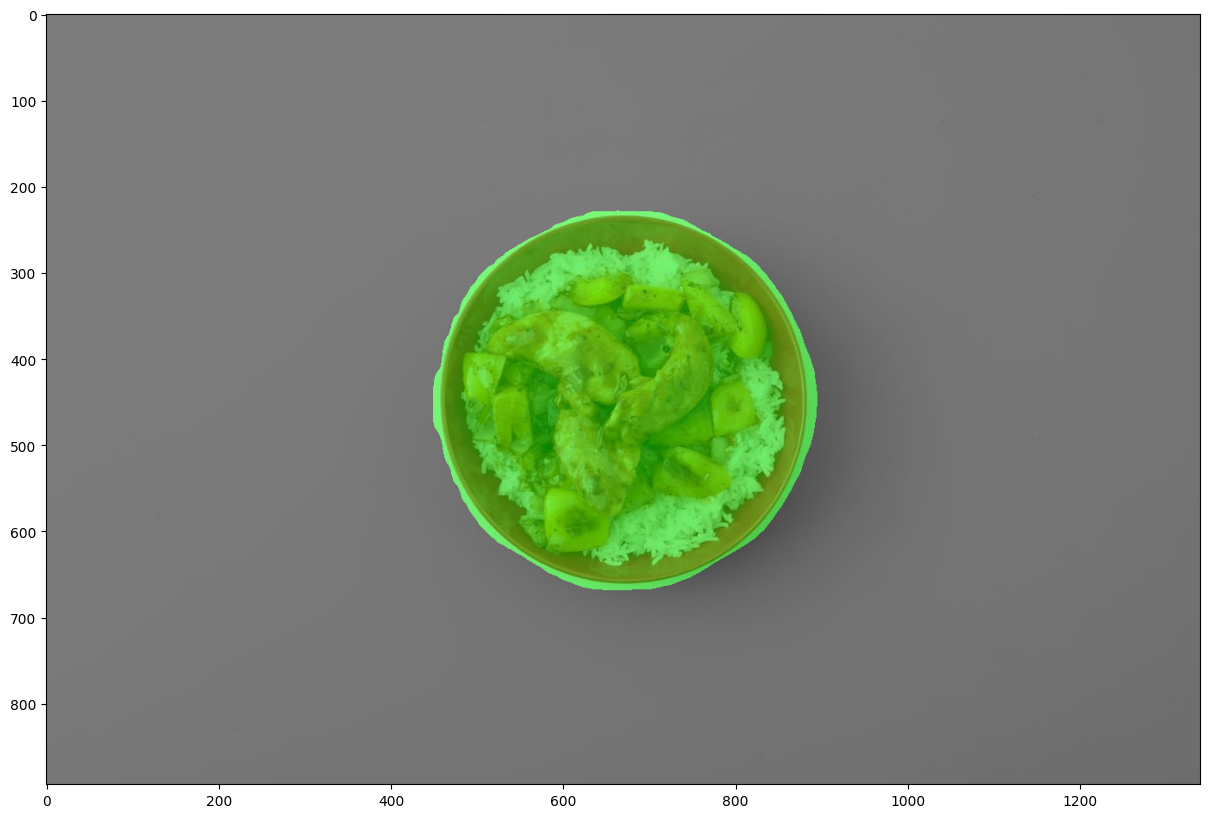

In [0]:
def visualize_segmentation(image_path: str, predicted_segmentation_map: np.ndarray):
    """
    Visualizes the segmentation map overlaid on the original image.

    Args:
        image_path: Path to the original image.
        predicted_segmentation_map: The predicted segmentation map.
    """
    def ade_palette() -> list[list[int]]:
        """
        Palette that maps each class to RGB values.
        
        Returns:
            A list of RGB values for each class.
        """
        return [[0, 0, 0], [0, 255, 0]]

    # Create an empty image with the same shape as the segmentation map
    color_seg = np.zeros((predicted_segmentation_map.shape[0],
                        predicted_segmentation_map.shape[1], 3), dtype=np.uint8)

    # Map each label to its corresponding color
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[predicted_segmentation_map == label, :] = color

    # Convert the color image from RGB to BGR (required by OpenCV)
    color_seg = color_seg[..., ::-1]

    # Open the image file
    image = Image.open(image_path)

    # Overlay the segmentation mask on the original image
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    # Visualize the result
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

# Post-process the model outputs to generate a segmentation map
predicted_segmentation_map = feature_extractor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

visualize_segmentation(image_path, predicted_segmentation_map)

##### Remove background

_Final result as returned by the API._

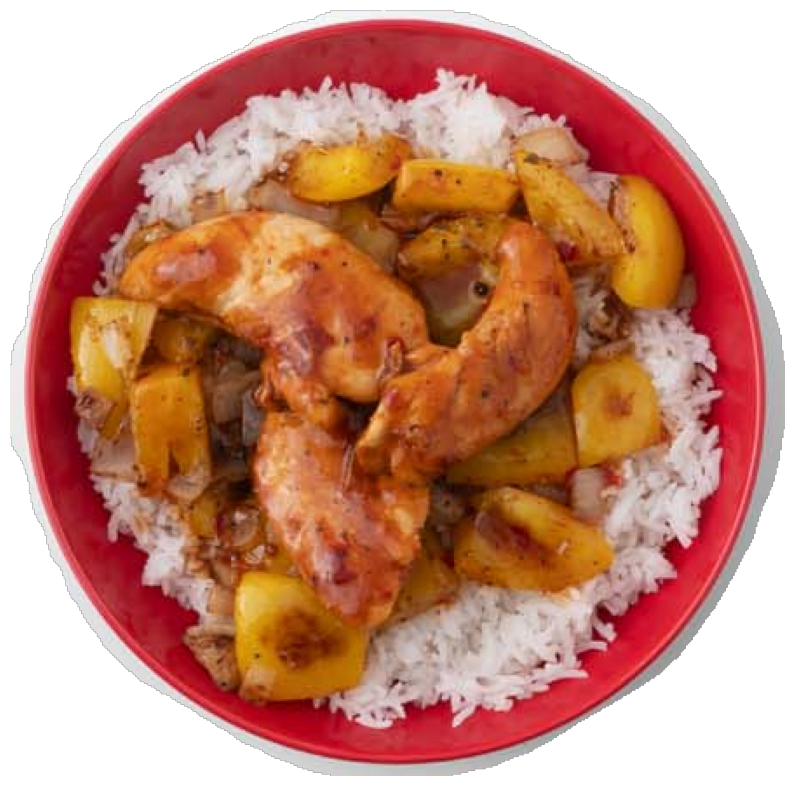

In [0]:
def crop_image_with_transparent_background(image_path: str, predicted_segmentation_map: np.ndarray):
    """
    Crops the original image based on the predicted segmentation map, removing everything
    that is background, and saves the cropped image with a transparent background as a .png file.

    Args:
        image_path: Path to the original image.
        predicted_segmentation_map: The predicted segmentation map.
    """
    # Load original image
    image = Image.open(image_path).convert("RGBA")

    # Convert segmentation map to binary mask (1 for foreground, 0 for background)
    binary_mask = (predicted_segmentation_map == 1).astype(np.uint8)

    # Create RGBA image for the mask
    mask = Image.new("L", (binary_mask.shape[1], binary_mask.shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    for y in range(binary_mask.shape[0]):
        for x in range(binary_mask.shape[1]):
            if binary_mask[y, x] == 1:
                draw.point((x, y), fill=255)

    # Apply mask to the original image to make the background transparent
    image_with_transparency = Image.composite(image, Image.new("RGBA", image.size), mask)

    # Find bounding box of foreground
    foreground_indices = np.where(binary_mask == 1)
    if len(foreground_indices[0]) == 0 or len(foreground_indices[1]) == 0:
        print("No foreground detected in the segmentation map.")
        return

    top_left_y = np.min(foreground_indices[0])
    bottom_right_y = np.max(foreground_indices[0])
    top_left_x = np.min(foreground_indices[1])
    bottom_right_x = np.max(foreground_indices[1])

    # Crop image with transparency using bounding box
    cropped_image_with_transparency = image_with_transparency.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

    # Visualize cropped image with transparency
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_image_with_transparency)
    plt.axis("off")
    plt.show()

# Crop the image based on the segmentation mask and save it
crop_image_with_transparent_background(image_path, predicted_segmentation_map)

#### Model Wrapper

Wrapping the fine-tuned model to handle model inference, cropping the image, and uploading the result to an S3 bucket.

- Create `RecipeCropper` wrapper ready for deployment.

In [0]:
class RecipeCropper(mlflow.pyfunc.PythonModel):
    """
    A custom model for performing image segmentation using a pre-trained Segformer model.
    This class generates the cropped version of an image and uploads the result to an S3 bucket.

    Args:
        model_path: Path to the pre-trained SegFormer model.
    """
    def __init__(self, model_path: str):
        self.model = SegformerForSemanticSegmentation.from_pretrained(model_path)
        self.feature_extractor = SegformerFeatureExtractor.from_pretrained(model_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def load_context(self, context):
        """
        Load context method to initialize non-pickleable objects.

        Args:
            context: MLflow context.
        """
        aws_default_region = os.getenv("AWS_DEFAULT_REGION")

        # Create S3 client
        self.s3 = boto3.client(
            "s3",
            region_name=aws_default_region
        )

        # Setup logging
        self._logger = logging.getLogger(__name__)
        self._logger.setLevel(logging.INFO)
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.info("Logger initialized in load_context")

    # Read file from DBFS
    def _read_file_from_dbfs(self, dbfs_path):
        """
        Read file from Databricks File System (DBFS).

        Args:
            dbfs_path: Path to the file in DBFS.

        Returns:
            The file content as a BytesIO object.
        """
        token = os.getenv("DATABRICKS_TOKEN")
        host = os.getenv("DATABRICKS_HOST")
        url = f"{host}/api/2.0/dbfs/read"
        headers = {"Authorization": f"Bearer {token}"}
        json_data = {"path": dbfs_path}
        response = requests.get(url, headers=headers, json=json_data)
        if response.status_code != 200:
            raise Exception(f"Failed to read file from DBFS: {response.text}")
        data = response.json()
        return BytesIO(base64.b64decode(data['data']))

    def predict(self, context, model_input) -> str:
        """
        Predicts the segmentation map of an image, crops the segmented region, and uploads it to S3.

        Args:
            context: The context of the MLflow model.
            model_input: Dictionary containing the input parameters within the 'inputs' key.
                - image_path: Path to the input image.

        Returns:
            URL of the uploaded image in the S3 bucket.
        """
        self._logger.info(f"Received model_input: {model_input}")

        # Get image path and bucket name
        image_path = model_input.get("image_path")
        bucket_name = os.getenv("BUCKET_NAME")

        if isinstance(image_path, np.ndarray):
            image_path = image_path.item()

        # Create s3_key from original image name
        original_image_name = os.path.basename(image_path)
        result_image_name = os.path.splitext(original_image_name)[0] + "_cropped.png"
        s3_key = "recipecropper/results/" + result_image_name

        self._logger.info(f"image_path: {image_path}")
        self._logger.info(f"bucket_name: {bucket_name}")
        self._logger.info(f"s3_key: {s3_key}")

        # Download image from URL or DBFS
        try:
            if image_path.startswith('http') or image_path.startswith('https'):
                self._logger.info("Downloading from URL...")
                response = requests.get(image_path)
                if response.status_code != 200:
                    raise Exception(f"Failed to download image from URL: {response.text}")
                image_data = BytesIO(response.content)
            else:
                self._logger.info("Reading from DBFS...")
                image_data = self._read_file_from_dbfs(image_path)
            image = Image.open(image_data).convert("RGB") # 21
        except Exception as e:
            self._logger.error(f"Error reading image: {e}")
            raise e

        self._logger.info("Image read successfully.")
        
        # Preprocess image using feature extractor
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(self.device)

        # Perform inference with model
        with torch.no_grad():
            outputs = self.model(pixel_values=pixel_values)
            logits = outputs.logits.cpu()

        # Post-process segmentation_map
        predicted_segmentation_map = self.feature_extractor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
        predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

        self._logger.info(f"Segmentation inference completed successfully.")

        # Crop the image
        local_path = self._crop_image(image, predicted_segmentation_map)

        # Upload to S3
        self.s3.upload_file(local_path, bucket_name, s3_key)
        s3_url = f"https://{bucket_name}.s3.{os.environ['AWS_DEFAULT_REGION']}.amazonaws.com/{s3_key}"
        self._logger.info(f"Successfully uploaded cropped image to S3 at: {s3_url}")

        # Delete local file after upload
        os.remove(local_path)
        self._logger.info(f"Local cropped image file deleted after upload.")

        return s3_url
    
    def _crop_image(self, image: Image.Image, predicted_segmentation_map: np.ndarray) -> str:
        """
        Crops the segmented region from the image and saves it locally with a transparent background.

        Args:
            image: Original image
            predicted_segmentation_map: Segmentation map.

        Returns:
            Local path to the cropped image.
        """
        # Create binary mask where the segmentation map == 1
        binary_mask = (predicted_segmentation_map == 1).astype(np.uint8)

        # Create a mask image and draw the binary mask on it
        mask = Image.new("L", (binary_mask.shape[1], binary_mask.shape[0]), 0)
        draw = ImageDraw.Draw(mask)
        for y in range(binary_mask.shape[0]):
            for x in range(binary_mask.shape[1]):
                if binary_mask[y, x] == 1:
                    draw.point((x, y), fill=255)

        # Apply mask to original image to create image with transparency
        image_with_transparency = Image.composite(image, Image.new("RGBA", image.size), mask)

        # Find bounding box of segmented region
        foreground_indices = np.where(binary_mask == 1)
        if len(foreground_indices[0]) == 0 or len(foreground_indices[1]) == 0:
            print("No foreground detected in segmentation map.")
            return
        
        top_left_y = np.min(foreground_indices[0])
        bottom_right_y = np.max(foreground_indices[0])
        top_left_x = np.min(foreground_indices[1])
        bottom_right_x = np.max(foreground_indices[1])

        # Crop the image to the bounding box
        cropped_image_with_transparency = image_with_transparency.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

        # Save the cropped image locally
        local_path = "/tmp/result.png"
        cropped_image_with_transparency.save(local_path, "PNG")

        self._logger.info(f"Cropped image saved locally at: {local_path}")

        return local_path

In [0]:
# Testing wrapper before deployment

model_path = "<PATH>/PoC/best_model_ex09"

custom_model = RecipeCropper(model_path=model_path)
context = None
custom_model.load_context(context)

image_path = 'https://res.cloudinary.com/image/R13_W13_DE_L19841-3_Main_low-ef495675.jpg'
model_input = {
    'image_path': image_path
}

s3_url = custom_model.predict(context, model_input)
print(f"Result uploaded to: {s3_url}")

#### Deployment

##### Deployment with Databricks
- Register model using MLflow
- Deploy using user interface
- Test endpoint

##### Register model

In [0]:
model_path = "<PATH>/PoC/model_ex09"

custom_model = RecipeCropper(model_path=model_path)

# Log the model
with mlflow.start_run() as run:
    mlflow.pyfunc.log_model(
        artifact_path="model",
        python_model=custom_model,
        conda_env={
            'name': 'mlflow-env',
            'channels': ['conda-forge'],
            'dependencies': [
                'python=3.10.12',
                'pip',
                {
                    'pip': [
                        'mlflow==2.14.2',
                        'torch==2.3.1',
                        'torchvision==0.18.1',
                        'transformers==4.42.3',
                        'evaluate==0.4.2',
                        'accelerate==0.32.1',
                        'boto3',
                        'pillow'
                    ]
                }
            ]
        }
    )

# Register the model
mlflow.register_model(
    model_uri=f"runs:/{run.info.run_id}/model",
    name="oma-recipecropper-v1"
)

##### Test endpoint

In [0]:
url = "https://company.cloud.databricks.com/serving-endpoints/oma-recipecropper-v1/invocations"
headers = {
    "Authorization": f"Bearer {os.environ.get('DATABRICKS_TOKEN')}",
    "Content-Type": "application/json"
}
data = {
    "inputs": {
        "image_path": "https://img.company.com/step-c1432550.jpg"
    }
}

response = requests.post(url, headers=headers, json=data)
print(response.json())

{'predictions': 'https://<AWS_BUCKET_NAME>.s3.<AWS_DEFAULT_REGION>.amazonaws.com/recipecropper/results/step-c1432550_cropped.png'}


#### Databricks DBFS

_Useful blocks to perform operations in DBFS._

- List folder contents
- Copy files between folders
- Get folder size
- Remove folder recursively
- Compress folder contents
- Upload file to S3 bucket
- Extract zip file

In [0]:
# List folder contents
%fs ls <PATH>/PoC

In [0]:
# Copy files between folders
source_folder = "<PATH>/PoC/step_dataset_processed_02"
destination_folder = "<PATH>/PoC/step_dataset_processed_01"

dbutils.fs.cp(source_folder, destination_folder, recurse=True)

In [0]:
# Get folder size
def get_directory_size(path):
    """
    Calculate the size of a directory in bytes.
    
    Args:
        path (str): The path of the directory.
    
    Returns:
        int: The total size of the directory in bytes.
    """
    total_size = 0
    try:
        files = dbutils.fs.ls(path)
        for file in files:
            if file.isDir():
                # Recursively calculate the size of subdirectories
                total_size += get_directory_size(file.path)
            else:
                total_size += file.size
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return total_size

# Calculate directory size
directory_path = "<PATH>/PoC/step_dataset_01"
directory_size = get_directory_size(directory_path)
print(f"Size of '{directory_path}': {directory_size / (1024 ** 3):.2f} GB")

In [0]:
# Remove folder recursively
folder_path = "<PATH>/step_dataset_01/processed"

dbutils.fs.rm(folder_path, recurse=True)

In [0]:
# Compress folder contents
dir_path = "<PATH>/finetuned-segformer-step_dataset_simple"
tar_gz_file = "<PATH>/finetuned-segformer-step_dataset_simple.tar.gz"

# Run the tar command to compress the directory
import os
os.system(f"tar -czvf {tar_gz_file} -C {dir_path} .")

In [0]:
# Upload file to S3 bucket
import os
import boto3

os.environ['AWS_ACCESS_KEY_ID'] = "****"
os.environ['AWS_SECRET_ACCESS_KEY'] = "****"
os.environ['AWS_DEFAULT_REGION'] = "<AWS_DEFAULT_REGION>"

# Create S3 client
s3 = boto3.client("s3")

# Define DBFS path and local path
dbfs_path = "dbfs:<PATH>/finetuned-segformer-step_dataset_simple.tar.gz"
local_path = "/tmp/finetuned-segformer-step_dataset_simple.tar.gz"

# Copy file from DBFS to local filesystem
dbutils.fs.cp(dbfs_path, "file:" + local_path)

# Define S3 bucket name and S3 key (path) where the file will be stored
bucket_name = "<AWS_BUCKET_NAME>"
s3_key = "finetuned-segformer-step_dataset_simple.tar.gz"

# Upload file to S3
s3.upload_file(local_path, bucket_name, s3_key)

print(f"File uploaded to S3 bucket: '{bucket_name}' with key: '{s3_key}'")

In [0]:
# Extract dataset.zip
import zipfile

dataset_name = "step_dataset_processed_02"

z_path = f'<PATH>/PoC/{dataset_name}.zip'
z_extract_to = f'<PATH>/PoC/'

with zipfile.ZipFile(z_path, 'r') as z_ref:
    z_ref.extractall(z_extract_to)